In [1]:
from fastqaoa import Diagonals, Statevector, optimize_qaoa_lbfgs
import qubovert as qv
import networkx as nx
from fastqaoa.ctypes.qaoa import apply_diagonals, qaoa

import numpy as np

from scipy.optimize import minimize

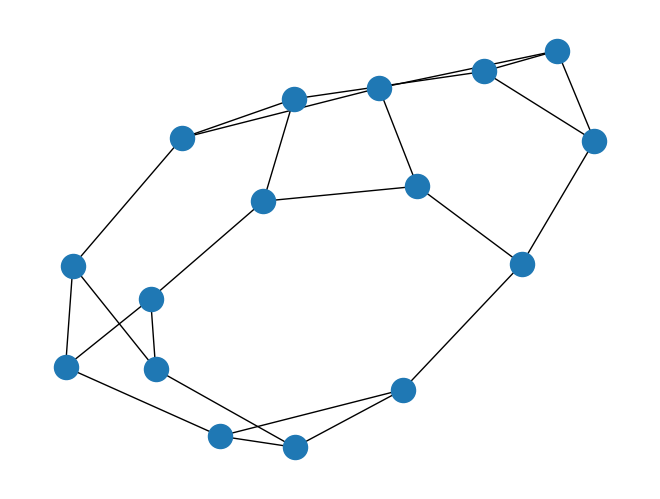

In [2]:
G = nx.random_regular_graph(3, 16)
nx.draw(G)

In [3]:
qubo = qv.QUSO({e: 1 for e in G.edges}).to_qubo()

In [4]:
qubo.solve_bruteforce()

{0: 0,
 1: 0,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 0,
 7: 1,
 8: 1,
 9: 0,
 10: 0,
 11: 0,
 12: 1,
 13: 1,
 14: 0,
 15: 0}

In [5]:
dg = Diagonals.brute_force_qv(qubo)
opt = dg.min_val


In [6]:
def layer(sv, beta, gamma):
    sv_np = sv.to_numpy()
    sv2 = apply_diagonals(sv, dg, gamma)
    sv2_np = sv2.to_numpy()
    dot = sv_np.conj().dot(sv2_np)
    # print(dot)
    sv2_np -= (1 - np.exp(-1j * beta)) * dot * sv_np
    sv = Statevector.from_numpy(sv2_np)
    return sv

def cost(sv):
    return dg.expec(sv)

In [39]:
sv = Statevector.make_plus_state(10)
# sv = qaoa(dg, 0.4 * np.ones(1), 0.4 * np.ones(1))


log = []
x = 0.5 * np.ones(2)
for _ in range(20):
    res = minimize(lambda x: cost(layer(sv, *x)), x0=x, method="BFGS")
    sv = layer(sv, *res.x)
    x = res.x
    log.append(res.fun)

In [40]:
log2 = []
b = 0.5 * np.ones(1)
g = 0.5 * np.ones(1)
for i in range(1, 21):
    res = optimize_qaoa_lbfgs(dg, dg, b, g)
    log2.append(res.log[-1])

    b = np.interp(np.linspace(0, 1, i + 1), np.linspace(0, 1, i), b)
    g = np.interp(np.linspace(0, 1, i + 1), np.linspace(0, 1, i), g)

In [41]:
import matplotlib.pyplot as plt

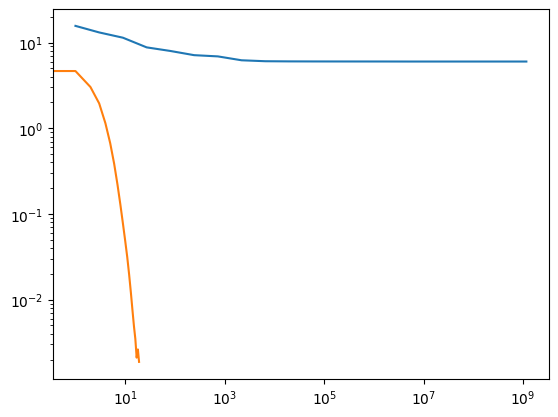

In [42]:
plt.plot(3 ** np.arange(20), np.array(log)-opt)
plt.plot(np.array(log2)-opt)
plt.yscale("log")
plt.xscale("log")